In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Measurement.__table__.columns.keys()


['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
M = session.query(Measurement)
for m in M:
    print(m.date)
    print(m.station)
    print(m.prcp)
    print(m.tobs)
    break

2010-01-01
USC00519397
0.08
65.0


In [12]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [13]:
S = session.query(Station)
for s in S:
    print(s.id)
    print(s.station)
    print(s.name)
    print(s.latitude)
    print(s.longitude)
    print(s.elevation)
    break

1
USC00519397
WAIKIKI 717.2, HI US
21.2716
-157.8168
3.0


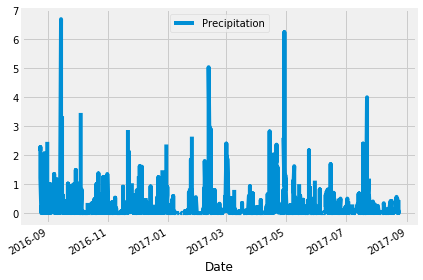

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date one year from the last date in data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago = dt.datetime.strftime(one_year_ago,'%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > one_year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# Sort the dataframe by date
df.sort_index(inplace=True)
#Use Pandas Plotting with Matplotlib to plot the data
df.plot(label='Precipitation')
plt.xlabel("Date")
plt.legend(('Precipitation',),loc='upper center', fontsize = 10)
plt.tight_layout()



In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).first()[0]

9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

id = most_active_stations[0][0]
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station == id).first()

(54.0, 85.0, 71.66378066378067)

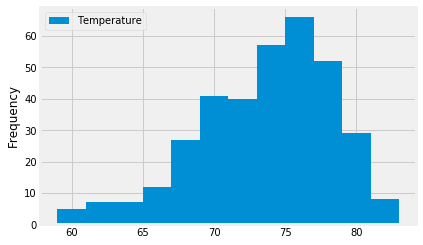

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.tobs).filter(Measurement.station == id).filter(Measurement.date > one_year_ago).all()
Temps =[]
for temp in temps:
    Temps.append(temp[0])

plt.hist(Temps, label = 'Temperature', bins=12)
plt.ylabel('Frequency')
plt.legend()

In [39]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).first()



In [40]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-01', '2017-01-07'))

(62.0, 68.36585365853658, 74.0)


Text(0,0.5,'Temperature(F)')

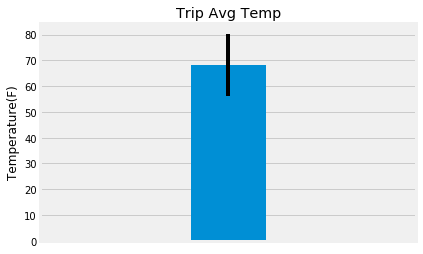

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin, tavg, tmax = calc_temps('2017-01-01', '2017-01-07')
plt.bar(0.5,height = tavg, yerr= tmax - tmin, width = 0.2, align = 'center')
plt.title('Trip Avg Temp')
plt.xlim(0,1)
plt.xticks([0,1],[])
plt.ylabel('Temperature(F)')

In [42]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
.join(Station, Station.station== Measurement.station).filter(Measurement.date >= '2017-01-01').filter(Measurement.date <= '2017-01-07').group_by(Measurement.station)\
.order_by(Measurement.prcp.desc()).all()


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5)]

## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start = '2018-01-01'
end = '2018-01-07'
# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start, end=end)
# Strip off the year and save a list of %m-%d strings
date_range_no_year = [dt.datetime.strftime(d,'%m-%d') for d in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in date_range_no_year:
    normals.append(daily_normals(date))
normals

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)]]

In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = [n[0][0]for n in normals]
tavg = [n[0][1]for n in normals]
tmax = [n[0][2]for n in normals]
df_normals = pd.DataFrame({'date':date_range, 'tmin':tmin, 'tavg':tavg, 'tmax':tmax})
df_normals = df_normals.set_index('date')
df_normals

,tavg,tmax,tmin
date,,,
2018-01-01,69.153846,77.0,62.0
2018-01-02,69.396226,77.0,60.0
2018-01-03,68.909091,77.0,62.0
2018-01-04,70.000000,76.0,58.0
2018-01-05,67.964286,76.0,56.0
2018-01-06,68.964912,76.0,61.0
2018-01-07,68.543860,76.0,57.0


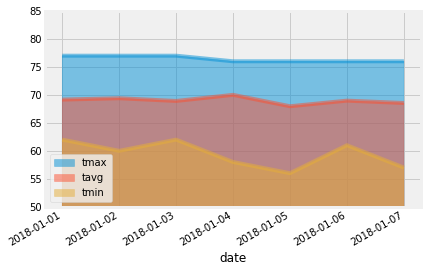

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals['tmax'].plot.area(x=df_normals.index,stacked=False,ylim=(50,85), legend=True, x_compat=True)
df_normals['tavg'].plot.area(x=df_normals.index,stacked=False,ylim=(50,85), legend=True)
df_normals['tmin'].plot.area(x=df_normals.index,stacked=False,ylim=(50,85), legend=True)

